# Emotion Classification using TAO EmotionNet

Transfer learning is the process of transferring learned features from one application to another. It is a commonly used training technique where you use a model trained on one task and re-train to use it on a different task. 

Train Adapt Optimize (TAO) Toolkit is a simple and easy-to-use Python based AI toolkit for taking purpose-built AI models and customizing them with users' own data.

<img align="center" src="https://developer.nvidia.com/sites/default/files/akamai/embedded-transfer-learning-toolkit-software-stack-1200x670px.png" width="1080"> 

## Learning Objectives
In this notebook, you will learn how to leverage the simplicity and convenience of TAO to:

* Take a pretrained model and train an EmotionNet model on subset of CK+ dataset
* Run Inference on the trained model
* Export the retrained model to a .etlt file for deployment for DeepStream SDK

### Table of Contents

This notebook shows an example of emotion classification in the Train Adapt Optimize (TAO) Toolkit.

0. [Set up env variables, map drives, and install dependencies](#head-0)
1. [Install the TAO launcher](#head-1)
2. [Prepare dataset and pre-trained model](#head-2) <br>
    2.1 [Verify downloaded dataset](#head-2-1) <br>
    2.2 [Convert dataset labels to required json format](#head-2-2) <br>
    2.3 [Verify dataset conversion](#head-2-3) <br>
    2.4 [Download pre-trained model](#head-2-4) <br>
3. [Generate tfrecords from labels in json format](#head-3)
4. [Provide training specification](#head-4)
5. [Run TAO training](#head-5)
6. [Evaluate trained models](#head-6)
7. [Run TAO inference](#head-7)
8. [Deploy](#head-8)


## 0. Set up env variables, map drives and install dependencies <a class="anchor" id="head-0"></a>
When using the purpose-built pretrained models from NGC, please make sure to set the `$KEY` environment variable to the key as mentioned in the model overview. Failing to do so, can lead to errors when trying to load them as pretrained models.

The following notebook requires the user to set an env variable called the `$LOCAL_PROJECT_DIR` as the path to the users' workspace. Please note that the dataset to run this notebook is expected to reside in the `$LOCAL_PROJECT_DIR/emotionnet/data`, while the TAO experiment generated collaterals will be output to `$LOCAL_PROJECT_DIR/emotionnet`. More information on how to set up the dataset and the supported steps in the TAO workflow are provided in the subsequent cells.

*Note: This notebook currently is by default set up to run training using 1 GPU. To use more GPU's please update the env variable `$NUM_GPUS` accordingly*

In [1]:
!pwd

/home/jupyter/emotionnet


In [2]:
# Setting up env variables for cleaner command line commands.
import os

%env KEY=nvidia_tlt
%env NUM_GPUS=1
#%env USER_EXPERIMENT_DIR=/workspace/tao-experiments/emotionnet
#%env DATA_DOWNLOAD_DIR=/workspace/tao-experiments/emotionnet/orgData

# Set this path if you don't run the notebook from the samples directory.
#%env NOTEBOOK_ROOT=/home/skouchak/test/emotionnet

# Please define this local project directory that needs to be mapped to the TAO docker session.
# The dataset is expected to be present in $LOCAL_PROJECT_DIR/emotionnet/orgData, while the results for the steps
# in this notebook will be stored at $LOCAL_PROJECT_DIR/emotionnet
# !PLEASE MAKE SURE TO UPDATE THIS PATH!.
%env LOCAL_PROJECT_DIR= /home/jupyter

# $SAMPLES_DIR is the path to the sample notebook folder and the dependency folder
# $SAMPLES_DIR/deps should exist for dependency installation
%env SAMPLES_DIR= /home/jupyter/emotionnet

os.environ["LOCAL_DATA_DIR"] = os.path.join(
    os.getenv("LOCAL_PROJECT_DIR", os.getcwd()),
    "emotionnet/orgData"
)
os.environ["LOCAL_EXPERIMENT_DIR"] = os.path.join(
    os.getenv("LOCAL_PROJECT_DIR", os.getcwd()),
    "emotionnet"
)

# The sample spec files are present in the same path as the downloaded samples.
os.environ["LOCAL_SPECS_DIR"] = os.path.join(
    os.getenv("LOCAL_PROJECT_DIR", os.getcwd()),
    "emotionnet/specs"
)

# The sample spec files are present in the same path as the downloaded samples.
os.environ["LOCAL_DATASET_SPECS_DIR"] = os.path.join(
    os.getenv("LOCAL_PROJECT_DIR", os.getcwd()),
    "emotionnet/dataset_specs"
)

#%env SPECS_DIR=/workspace/tao-experiments/emotionnet/specs
#%env DATASET_SPECS_DIR=/workspace/tao-experiments/emotionnet/dataset_specs

# Showing list of specification files.
!ls -rlt $LOCAL_SPECS_DIR
!ls -rlt $LOCAL_DATASET_SPECS_DIR
print("experiment directory")
!ls -rlt $LOCAL_EXPERIMENT_DIR

env: KEY=nvidia_tlt
env: NUM_GPUS=1
env: LOCAL_PROJECT_DIR=/home/jupyter
env: SAMPLES_DIR=/home/jupyter/emotionnet
total 8
-rw-r--r-- 1 jupyter jupyter 3311 Jul 15 17:14 emotionnet_tlt_pretrain.yaml
-rw-r--r-- 1 jupyter jupyter 3238 Jul 15 17:14 emotionnet_tlt.yaml
total 4
-rw-r--r-- 1 jupyter jupyter 429 Jul 15 17:15 dataio_config_ckplus.json
experiment directory
total 392
-rw-r--r-- 1 jupyter jupyter  10619 Jun 15 19:23 ckplus_convert.py
drwxr-xr-x 3 jupyter jupyter   4096 Jul 15 17:11 orgData
-rw-r--r-- 1 jupyter jupyter    196 Jul 15 17:14 requirements-pip.txt
drwxr-xr-x 2 jupyter jupyter   4096 Jul 15 17:14 specs
drwxr-xr-x 2 jupyter jupyter   4096 Jul 15 17:15 dataset_specs
-rw-r--r-- 1 jupyter jupyter 371714 Jul 15 17:15 emotionnet.ipynb


In [4]:
# Install requirement
!pip3 install -r $SAMPLES_DIR/requirements-pip.txt

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 2.9 MB 5.4 MB/s            
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [5]:
# Please replace fixme with the path to the wheel file that you downloaded from the developer zone link mentioned above.
# SKIP this step IF you have already installed the TAO launcher wheel.
#!pip3 install nvidia-tao

In [5]:
# Initialize the TAO launcher
#!tao info

Configuration of the TAO Toolkit Instance
dockers: ['nvidia/tao/tao-toolkit-tf', 'nvidia/tao/tao-toolkit-pyt', 'nvidia/tao/tao-toolkit-lm']
format_version: 2.0
toolkit_version: 3.22.05
published_date: 05/25/2022


## 2. Prepare dataset and pre-trained model <a class="anchor" id="head-2"></a>

Please download the CK+ dataset from: https://www.pitt.edu/~emotion/ck-spread.htm.
You will need to sign the dataset user agreement and send it to the email provided on the agreement sheet to get access to the dataset.

After obtaining the dataset, please place the files in `$DATA_DOWNLOAD_DIR`. Please rename the dataset folder to `ckplus` as `+` sign may not be a valid folder name.
You will then have the following path for the CK+ dataset.
* Input data in `$LOCAL_DATA_DIR/ckplus`

You will then unzip the folder of ckplus dataset to the following folders.
* Image data: `$LOCAL_DATA_DIR/ckplus/cohn-kanade-images`
* Emotion label data: `$LOCAL_DATA_DIR/ckplus/Emotion`
* Landmarks label data: `$LOCAL_DATA_DIR/ckplus/Landmarks`

Note: please make sure that the folder name are as listed above. 

### A. Verify downloaded dataset <a class="anchor" id="head-2-1"></a>


In [5]:
# Check the dataset is present
!mkdir -p $LOCAL_DATA_DIR
!if [ ! -d $LOCAL_DATA_DIR/ckplus/cohn-kanade-images ]; then echo 'Image Data folder not found, please download.'; else echo 'Found Image Data folder.';fi
!if [ ! -d $LOCAL_DATA_DIR/ckplus/Emotion ]; then echo 'Emotion labels folder not found, please download.'; else echo 'Found Emotion Labels folder.';fi
!if [ ! -d $LOCAL_DATA_DIR/ckplus/Landmarks ]; then echo 'Landmarks labels folder not found, please download.'; else echo 'Found Landmarks Labels folder.';fi

Found Image Data folder.
Found Emotion Labels folder.
Found Landmarks Labels folder.


### B. Convert dataset labels to required json format <a class="anchor" id="head-2-2"></a>

In [6]:
!python3 ckplus_convert.py --root_path $LOCAL_EXPERIMENT_DIR --dataset_folder_name ckplus --container_root_path $LOCAL_EXPERIMENT_DIR

/home/jupyter/emotionnet/orgData/ckplus/data_factory/fiducial
Generate json:  /home/jupyter/emotionnet/orgData/ckplus/data_factory/fiducial/S064_001_00000001_neutral.json
Generate json:  /home/jupyter/emotionnet/orgData/ckplus/data_factory/fiducial/S064_001_00000011_surprise.json
Generate json:  /home/jupyter/emotionnet/orgData/ckplus/data_factory/fiducial/S064_001_00000012_surprise.json
Generate json:  /home/jupyter/emotionnet/orgData/ckplus/data_factory/fiducial/S064_004_00000001_neutral.json
Generate json:  /home/jupyter/emotionnet/orgData/ckplus/data_factory/fiducial/S064_004_00000013_sad.json
Generate json:  /home/jupyter/emotionnet/orgData/ckplus/data_factory/fiducial/S064_004_00000014_sad.json
Generate json:  /home/jupyter/emotionnet/orgData/ckplus/data_factory/fiducial/S064_003_00000001_neutral.json
Generate json:  /home/jupyter/emotionnet/orgData/ckplus/data_factory/fiducial/S064_003_00000002_neutral.json
Generate json:  /home/jupyter/emotionnet/orgData/ckplus/data_factory/fid

### C. Verify dataset conversion <a class="anchor" id="head-2-3"></a>

Please use the provided conversion script `ckplus_convert.py` to convert existing `Landmarks` and `Emotion` labels from `CK+` dataset to the required json label format. 

Note: for other public datasets, please use this script as a reference to convert the labels to required format. 

In [7]:
# Sample json label.
!sed -n 1,201p $LOCAL_DATA_DIR/ckplus/data_factory/fiducial/S052_004_00000031_happy.json

[
    {
        "class": "image",
        "filename": "/home/jupyter/emotionnet/orgData/ckplus/cohn-kanade-images/S052/004/S052_004_00000031.png",
        "annotations": [
            {
                "class": "FaceBbox",
                "face_tight_bboxx": "206",
                "face_tight_bboxy": "180",
                "face_tight_bboxwidth": "230",
                "face_tight_bboxheight": "240"
            },
            {
                "tool-version": "1.0",
                "class": "FiducialPoints",
                "P1x": 208.33680725097656,
                "P1y": 226.58407592773438,
                "P2x": 206.01856994628906,
                "P2y": 257.5336608886719,
                "P3x": 207.5973358154297,
                "P3y": 288.521484375,
                "P4x": 212.08326721191406,
                "P4y": 318.9974670410156,
                "P5x": 224.4800567626953,
                "P5y": 347.2018127441406,
                "P6x": 240.9999542236328,
                "P6y": 3

### D. Download pre-trained model <a class="anchor" id="head-2-4"></a>

Please follow the instructions in the following to download and verify the pretrain model for emotionnet.

For EmotionNet pretrain model please download model: `nvidia/tao/emotionnet:trainable_v1.0`.

After downloading the pre-trained model, please place the files in `$LOCAL_EXPERIMENT_DIR/pretrain_models`
You will then have the following path

* pretrain model in `$LOCAL_EXPERIMENT_DIR/pretrain_models/emotionnet_vtrainable_v1.0/model.tlt`

In [8]:
# Installing NGC CLI on the local machine.
## Download and install
%env CLI=ngccli_cat_linux.zip
!mkdir -p $LOCAL_PROJECT_DIR/ngccli

# Remove any previously existing CLI installations
!rm -rf $LOCAL_PROJECT_DIR/ngccli/*
!wget "https://ngc.nvidia.com/downloads/$CLI" -P $LOCAL_PROJECT_DIR/ngccli
!unzip -u "$LOCAL_PROJECT_DIR/ngccli/$CLI" -d $LOCAL_PROJECT_DIR/ngccli/
!rm $LOCAL_PROJECT_DIR/ngccli/*.zip 
os.environ["PATH"]="{}/ngccli/ngc-cli:{}".format(os.getenv("LOCAL_PROJECT_DIR", ""), os.getenv("PATH", ""))

env: CLI=ngccli_cat_linux.zip
--2022-07-15 17:21:10--  https://ngc.nvidia.com/downloads/ngccli_cat_linux.zip
Resolving ngc.nvidia.com (ngc.nvidia.com)... 13.32.164.11, 13.32.164.13, 13.32.164.19, ...
Connecting to ngc.nvidia.com (ngc.nvidia.com)|13.32.164.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33949316 (32M) [application/zip]
Saving to: ‘/home/jupyter/ngccli/ngccli_cat_linux.zip’

ngccli_cat_linux.zi 100%[===================>]  32.38M  41.9MB/s    in 0.8s    

2022-07-15 17:21:11 (41.9 MB/s) - ‘/home/jupyter/ngccli/ngccli_cat_linux.zip’ saved [33949316/33949316]

Archive:  /home/jupyter/ngccli/ngccli_cat_linux.zip
   creating: /home/jupyter/ngccli/ngc-cli/
   creating: /home/jupyter/ngccli/ngc-cli/wcwidth/
  inflating: /home/jupyter/ngccli/ngc-cli/wcwidth/version.json  
   creating: /home/jupyter/ngccli/ngc-cli/frozenlist/
  inflating: /home/jupyter/ngccli/ngc-cli/frozenlist/_frozenlist.cpython-39-x86_64-linux-gnu.so  
  inflating: /home/jupyter/ng

In [9]:
# List models available in the model registry.
!ngc registry model list nvidia/tao/emotionnet:*

+-------+-------+-------+-------+-------+-------+------+-------+-------+
| Versi | Accur | Epoch | Batch | GPU   | Memor | File | Statu | Creat |
| on    | acy   | s     | Size  | Model | y Foo | Size | s     | ed    |
|       |       |       |       |       | tprin |      |       | Date  |
|       |       |       |       |       | t     |      |       |       |
+-------+-------+-------+-------+-------+-------+------+-------+-------+
| train | 91.0  | 100   | 1     | V100  | 4.4   | 4.38 | UPLOA | Aug   |
| able_ |       |       |       |       |       | MB   | D_COM | 19,   |
| v1.0  |       |       |       |       |       |      | PLETE | 2021  |
| deplo | 91.0  | 100   | 1     | V100  | 4.3   | 4.33 | UPLOA | Aug   |
| yable |       |       |       |       |       | MB   | D_COM | 19,   |
| _v1.0 |       |       |       |       |       |      | PLETE | 2021  |
+-------+-------+-------+-------+-------+-------+------+-------+-------+


In [10]:
# Create the target destination to download the model.
!mkdir -p $LOCAL_EXPERIMENT_DIR/pretrain_models/

In [11]:
# Download the pretrained model from NGC
!ngc registry model download-version nvidia/tao/emotionnet:trainable_v1.0 \
    --dest $LOCAL_EXPERIMENT_DIR/pretrain_models/

Downloaded 4.38 MB in 3s, Download speed: 1.45 MB/s               
----------------------------------------------------
Transfer id: emotionnet_vtrainable_v1.0 Download status: Completed.
Downloaded local path: /home/jupyter/emotionnet/pretrain_models/emotionnet_vtrainable_v1.0
Total files downloaded: 1 
Total downloaded size: 4.38 MB
Started at: 2022-07-15 17:22:01.272325
Completed at: 2022-07-15 17:22:04.281385
Duration taken: 3s
----------------------------------------------------


In [12]:
!ls -rlt $LOCAL_EXPERIMENT_DIR/pretrain_models/emotionnet_vtrainable_v1.0

total 4484
-rw------- 1 jupyter jupyter 4588024 Jul 15 17:22 model.tlt


In [13]:
# Check the dataset is present
!if [ ! -f $LOCAL_EXPERIMENT_DIR/pretrain_models/emotionnet_vtrainable_v1.0/model.tlt ]; then echo 'Pretrain model file not found, please download.'; else echo 'Found Pretrain model file.';fi

Found Pretrain model file.


In [14]:
import h5py
print(h5py.__version__)

2.8.0


## 3. Generate tfrecords from labels in json format <a class="anchor" id="head-3"></a>
* Create the tfrecords using the dataset_convert command


In [15]:
!emotionnet dataset_convert -c $LOCAL_DATASET_SPECS_DIR/dataio_config_ckplus.json

2022-07-15 17:22:58.235663: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.

2022-07-15 17:23:19,096 [WARNING] tensorflow: From /root/.cache/bazel/_bazel_root/ed34e6d125608f91724fda23656f1726/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/detectnet_v2/tfhooks/checkpoint_saver_hook.py:25: The name tf.train.CheckpointSaverHook is deprecated. Please use tf.estimator.CheckpointSaverHook instead.

Using TensorFlow backend.

2022-07-15 17:23:23,458 [WARNING] tensorflow: From /root/.cache/bazel/_bazel_root/ed34e6d125608f91724fda23656f1726/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/detectnet_v2/tfhooks/checkpoint_saver_hook.py:25: The name tf.train.CheckpointSaverHook is deprecated. Please use tf.estimator.CheckpointSaverHook instead.


2022-07-15 17:23:23,478 [WARNING] tensorflow: From /root/

In [16]:
# Check the result folder is present
!mkdir -p $LOCAL_EXPERIMENT_DIR
!if [ ! -d $LOCAL_EXPERIMENT_DIR/postData/ckplus/Ground_Truth_DataFactory ]; then echo 'Ground truth folder not found.'; else echo 'Found Ground truth folder.';fi
!if [ ! -d $LOCAL_EXPERIMENT_DIR/postData/ckplus/GT_user_json ]; then echo 'GT user json folder not found.'; else echo 'Found GT user json folder.';fi

Found Ground truth folder.
Found GT user json folder.


## 4. Provide training specification <a class="anchor" id="head-4"></a>
* Tfrecords for the train datasets
    * In order to use the newly generated tfrecords for training, update the 'ground_truth_folder_name' and 'tfrecords_directory_path' parameters of 'dataset_info' section in the spec file at `$LOCAL_SPECS_DIR/emotionnet_tlt_pretrain.yaml`
* Pre-trained model path
    * Update "pretrained_model_path" in the spec file at `$LOCAL_SPECS_DIR/emotionnet_tlt_pretrain.yaml`
    * If you want to training from random weights with your own data, you can enter "null" for "pretrained_model_path" section
* Augmentation parameters for on the fly data augmentation
* Other training (hyper-)parameters such as batch size, number of epochs, learning rate etc.

In [17]:
!cat $LOCAL_SPECS_DIR/emotionnet_tlt_pretrain.yaml

__class_name__: EmotionNetTrainer
checkpoint_dir: null
random_seed: 42
log_every_n_secs: 10
checkpoint_n_epoch: 1
num_epoch: 50
infrequent_summary_every_n_steps: 0
use_landmarks_input: True
class_list: ['neutral',
             'happy',
             'surprise',
             'contempt', 
             'disgust',
             'angry']
dataloader:
  __class_name__: EmotionNetDataloader
  batch_size: 64
  face_scale_factor: 1.3
  num_keypoints: 68
  prefetch_num: 3
  image_info:
    image_frame:
      channel: 1
      height: 480
      width: 640
    image_face:
      channel: 1
      height: 224
      width: 224
  dataset_info:
    root_path: null
    image_extension: png
    tfrecords_directory_path:
    - /home/jupyter/emotionnet/postData
    tfrecords_set_id:
    - ckplus
    ground_truth_folder_name:
    - Ground_Truth_DataFactory
    tfrecord_folder_name:
    - TfRecords_combined
    train_file_name: train.tfrecords
    validate_file_name: validate.tfrecords
    test_file_name: test.tf

## 5. Run TAO training <a class="anchor" id="head-5"></a>
* Provide the sample spec file and the output directory location for models

*Note: The training may take hours to complete. Also, the remaining notebook, assumes that the training was done in single-GPU mode. 

In [18]:
!ls -rlt $LOCAL_SPECS_DIR

total 8
-rw-r--r-- 1 jupyter jupyter 3311 Jul 15 17:14 emotionnet_tlt_pretrain.yaml
-rw-r--r-- 1 jupyter jupyter 3238 Jul 15 17:14 emotionnet_tlt.yaml


In [19]:
!ls -rlt $LOCAL_EXPERIMENT_DIR

total 396
-rw-r--r-- 1 jupyter jupyter  10619 Jun 15 19:23 ckplus_convert.py
drwxr-xr-x 3 jupyter jupyter   4096 Jul 15 17:11 orgData
drwxr-xr-x 2 jupyter jupyter   4096 Jul 15 17:14 specs
drwxr-xr-x 2 jupyter jupyter   4096 Jul 15 17:15 dataset_specs
-rw-r--r-- 1 jupyter jupyter    189 Jul 15 17:17 requirements-pip.txt
drwxr-xr-x 3 jupyter jupyter   4096 Jul 15 17:22 pretrain_models
drwxr-xr-x 3 jupyter jupyter   4096 Jul 15 17:23 postData
-rw-r--r-- 1 jupyter jupyter 367327 Jul 15 17:23 emotionnet.ipynb


In [20]:
!emotionnet train -e $LOCAL_SPECS_DIR/emotionnet_tlt_pretrain.yaml \
                      -r $LOCAL_EXPERIMENT_DIR/experiment_result/exp1 \
                      -k $KEY

2022-07-15 17:24:25.101558: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.

2022-07-15 17:24:28,236 [WARNING] tensorflow: From /root/.cache/bazel/_bazel_root/ed34e6d125608f91724fda23656f1726/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/detectnet_v2/tfhooks/checkpoint_saver_hook.py:25: The name tf.train.CheckpointSaverHook is deprecated. Please use tf.estimator.CheckpointSaverHook instead.

Using TensorFlow backend.

2022-07-15 17:24:32,669 [WARNING] tensorflow: From /root/.cache/bazel/_bazel_root/ed34e6d125608f91724fda23656f1726/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/detectnet_v2/tfhooks/checkpoint_saver_hook.py:25: The name tf.train.CheckpointSaverHook is deprecated. Please use tf.estimator.CheckpointSaverHook instead.


2022-07-15 17:24:32,670 [WARNING] tensorflow: From /root/

In [21]:
!ls -lh $LOCAL_EXPERIMENT_DIR/experiment_result

total 4.0K
drwxr-xr-x 2 jupyter jupyter 4.0K Jul 15 17:26 exp1


## 6. Evaluate the trained model <a class="anchor" id="head-6"></a>


In [23]:
!emotionnet evaluate -m $LOCAL_EXPERIMENT_DIR/experiment_result/exp1/model.tlt \
                         -r $LOCl_EXPERIMENT_DIR/experiment_result/exp1 \
                         -e $LOCAL_SPECS_DIR/emotionnet_tlt_pretrain.yaml \
                         -k $KEY

2022-07-15 17:35:21.452657: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.

2022-07-15 17:35:24,548 [WARNING] tensorflow: From /root/.cache/bazel/_bazel_root/ed34e6d125608f91724fda23656f1726/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/detectnet_v2/tfhooks/checkpoint_saver_hook.py:25: The name tf.train.CheckpointSaverHook is deprecated. Please use tf.estimator.CheckpointSaverHook instead.

Using TensorFlow backend.

2022-07-15 17:35:28,899 [WARNING] tensorflow: From /root/.cache/bazel/_bazel_root/ed34e6d125608f91724fda23656f1726/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/detectnet_v2/tfhooks/checkpoint_saver_hook.py:25: The name tf.train.CheckpointSaverHook is deprecated. Please use tf.estimator.CheckpointSaverHook instead.


2022-07-15 17:35:28,899 [WARNING] tensorflow: From /root/

In [ ]:
# check the Evaluation result file and summary file and is presented
!if [ ! -f $LOCAL_EXPERIMENT_DIR/experiment_result/exp1/eval_results.txt ]; then echo 'Evaluation result summary file not found, please generate.'; else echo 'Found Evaluation result summary file.';fi
!if [ ! -f $LOCAL_EXPERIMENT_DIR/experiment_result/exp1/full_results.txt ]; then echo 'Evaluation result file not found, please generate.'; else echo 'Found Evaluation result file.';fi

## 7. Visualize Inference <a class="anchor" id="head-7"></a>

In this section, we run the inference tool to generate inferences on the trained models.

In [24]:
# Running inference for detection on n images
!emotionnet inference -e $LOCAL_SPECS_DIR/emotionnet_tlt_pretrain.yaml \
                          -i $LOCAL_DATA_DIR/ckplus/data_factory/fiducial/S111_001_00000013_surprise.json \
                          -m $LOCAL_EXPERIMENT_DIR/experiment_result/exp1/model.tlt \
                          -o $LOCAL_EXPERIMENT_DIR \
                          -k $KEY 

2022-07-15 17:41:44.481646: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.

2022-07-15 17:41:47,633 [WARNING] tensorflow: From /root/.cache/bazel/_bazel_root/ed34e6d125608f91724fda23656f1726/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/detectnet_v2/tfhooks/checkpoint_saver_hook.py:25: The name tf.train.CheckpointSaverHook is deprecated. Please use tf.estimator.CheckpointSaverHook instead.

Using TensorFlow backend.

2022-07-15 17:41:52,001 [WARNING] tensorflow: From /root/.cache/bazel/_bazel_root/ed34e6d125608f91724fda23656f1726/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/detectnet_v2/tfhooks/checkpoint_saver_hook.py:25: The name tf.train.CheckpointSaverHook is deprecated. Please use tf.estimator.CheckpointSaverHook instead.

/home/jupyter/emotionnet
/usr/local/lib/python3.6/dist-pac

In [25]:
!sed -n 1,1p $LOCAL_EXPERIMENT_DIR/result.txt

/home/jupyter/emotionnet/orgData/ckplus/cohn-kanade-images/S111/001/S111_001_00000013.png surprise 


In [26]:
# Simple emotion inference overlay visualizer
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import os
import IPython.display
import PIL.Image


def visualize_images(output_path, num_images=10):
    root_path = os.path.join(os.environ['LOCAL_EXPERIMENT_DIR'], output_path)
    result_path = os.path.join(root_path, 'result.txt')
    f = open(result_path, 'r')
    lines = f.readlines()
    
    for k in range(0, num_images):
        line = lines[k]
        content = line.split(' ')
        docker_data_path = os.environ['LOCAL_DATA_DIR']
        print(docker_data_path)
        path_info = content[0].split(str(docker_data_path))
        image_path = os.environ['LOCAL_DATA_DIR'] + path_info[-1]
        emotion_label = content[1]
        print(image_path, emotion_label)
        img = cv2.imread(image_path, 0)
        cv2.putText(img, "Emotion: " + emotion_label, (40, 40), 0, 1, 255)
        IPython.display.display(PIL.Image.fromarray(img))

/home/jupyter/emotionnet/orgData
/home/jupyter/emotionnet/orgData/ckplus/cohn-kanade-images/S111/001/S111_001_00000013.png surprise


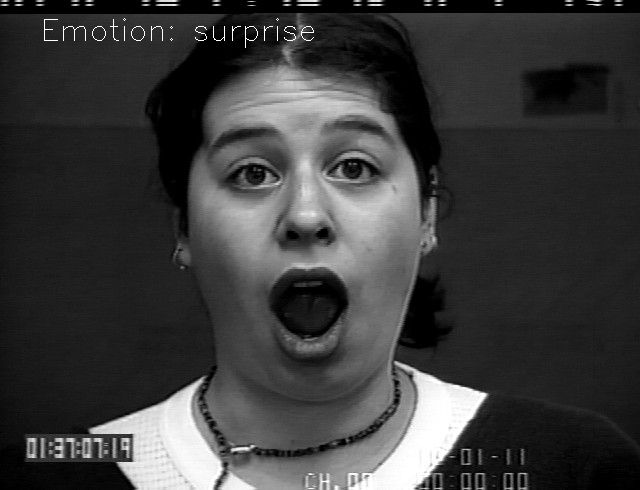

In [27]:
# Visualizing the first 2 images.
OUTPUT_PATH = '' # relative path from $USER_EXPERIMENT_DIR.
IMAGES = 1
visualize_images(OUTPUT_PATH, num_images=IMAGES)

## 8. Deploy <a class="anchor" id="head-7"></a>

In [29]:
!mkdir -p $LOCAL_EXPERIMENT_DIR/experiment_dir_final
# Removing a pre-existing copy of the etlt if there has been any.
import os
output_file=os.path.join(os.environ['LOCAL_EXPERIMENT_DIR'],
                         "experiment_dir_final/emotionnet_onnx.etlt")
if os.path.exists(output_file):
    os.system("rm {}".format(output_file))
!emotionnet export -m $LOCAL_EXPERIMENT_DIR/experiment_result/exp1/model.tlt \
                       -o $LOCAL_EXPERIMENT_DIR/experiment_dir_final/emotionnet_onnx.etlt \
                       -t tfonnx \
                       -k $KEY

2022-07-15 17:49:38.220382: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.

2022-07-15 17:49:41,286 [WARNING] tensorflow: From /root/.cache/bazel/_bazel_root/ed34e6d125608f91724fda23656f1726/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/detectnet_v2/tfhooks/checkpoint_saver_hook.py:25: The name tf.train.CheckpointSaverHook is deprecated. Please use tf.estimator.CheckpointSaverHook instead.

Using TensorFlow backend.
2022-07-15 17:49:45,665 [WARNING] /usr/local/lib/python3.6/dist-packages/driveix/emotionnet/scripts/export.pyc: Please verify the input dimension and input name before using this code!!!

2022-07-15 17:49:45,798 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.


2022-07-15 17:49:45,812 [

In [30]:
# check the Deployed file is presented
!if [ ! -f $LOCAL_EXPERIMENT_DIR/experiment_dir_final/emotionnet_onnx.etlt ]; then echo 'Deployed file not found, please generate.'; else echo 'Found Deployed file folder.';fi

Found Deployed file folder.
